In [1]:
import keras
import numpy as np
from keras import backend as K
from random import shuffle
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(keras.__version__)

Using TensorFlow backend.


2.2.4


In [2]:
from keras import backend as k
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

k.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
batch_size = 64
IMAGE_SIZE = 64
epochs = 40
num_classes = 5

In [4]:
# train = np.load("/home/cudacenter/DR/DenseNet_Finetune/Train64x64.npy")
# X_train = np.array([i[0] for i in train]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
# Y_train = np.array([i[1] for i in train])
# # np.save("/home/cudacenter/DR/DenseNet_Bottleneck/labels_train.npy", np.array([i[1] for i in train]))

# del train
# print("Train Loaded")

In [5]:
# train = np.load("/home/cudacenter/DR/DenseNet_Finetune/Val64x64.npy")
train = np.load("F:/DR/Final_NPYs_6March/TestFinal6Mx64x64.npy")

X_test = np.array([i[0] for i in train]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
Y_test = np.array([i[1] for i in train])
# np.save("/home/cudacenter/DR/DenseNet_Bottleneck/labels_test.npy", np.array([i[1] for i in train]))

del train
print("Test Loaded")

Test Loaded


[0]


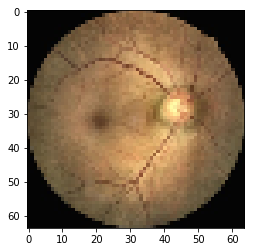

In [6]:
img = X_test[45]
print(Y_test[45])
imgplot = plt.imshow(img)

In [7]:
# unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [8]:
unique_elements, counts_elements = np.unique(Y_test, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  0   1   2   3   4]
 [150 150 150 150 150]]


In [9]:
# X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# X_train /= 255
X_test /= 255

# Y_train = keras.utils.to_categorical(Y_train,num_classes)
Y_test = keras.utils.to_categorical(Y_test,num_classes)

In [10]:
input = Input(shape=(64,64,3))

base_model = DenseNet121(include_top = False,input_tensor = input,  input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), classes = 5)
type(base_model)

keras.engine.training.Model

In [11]:
for layer in base_model.layers[:427]:
    layer.trainable = True
    
    
# # for layer in base_model.layers[141:]:
# #     layer.trainable = True

# countt = 0
# for i in base_model.layers:
#     print(str(countt)+" "+str(i.get_config()))
#     print()
#     countt += 1


In [12]:
x = base_model.output
x = Flatten()(x)
x = Dense(8192, activation='relu')(x)
# x = Dropout(0.7)(x)
x = Dense(1024, activation='relu')(x)
# x = Dropout(0.7)(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.7)(x)
pred = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = input, outputs = pred)
model.summary()

# 64x64x3 dir

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [13]:
model.load_weights("test.h5")

In [14]:
## CREATE DIRECTORY FIRST /home/cudacenter/DR/FINAL_05Feb/Pretrained/DenseNet_Weights_t1
sgd = SGD(lr=1e-4, decay=1e-6, momentum = 0.9, nesterov=True)
# checkpoint = ModelCheckpoint('/home/cudacenter/DR/DenseNet_Finetune/64x64x3/DN121x64-{epoch:03d}-.h5',verbose = 1,monitor = 'acc',save_best_only = True,mode = "auto")
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])

In [15]:
# model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test), callbacks=[checkpoint])

In [16]:
# model.load_weights("/home/cudacenter/DR/DenseNet_Finetune/64x64x2/DN121x64-022-.h5")
score = model.evaluate(X_test,Y_test,verbose=1)
print("Test Loss : ",score[0])
print("Test Accuracy : ",score[1])

750/750 [==============================] - 13s 17ms/step
Test Loss :  1.4372932643890381
Test Accuracy :  0.745333333492279


In [17]:
# model.save_weights('/home/cudacenter/DR/DenseNet_Finetune/64x64x3/DR_weights_{}_DN121F64.h5'.format(score[1]))

In [18]:
Y_pred = model.predict(X_test,verbose = 1)

750/750 [==============================] - 6s 9ms/step


In [19]:
# print(Y_pred)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test.argmax(axis = 1), Y_pred.argmax(axis = 1))

In [20]:
print(conf_mat)

[[121  14  15   0   0]
 [ 35 103  11   1   0]
 [ 27   7 112   2   2]
 [  9   7  27 102   5]
 [  9   0  17   3 121]]


In [21]:
sens1 = (float)(conf_mat[4,4]) / (float)(6000) 
print(sens1)

0.020166666666666666
